In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import glob
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from time import time
from torchsummary import summary
import math
import copy
import csv

In [2]:
lr = 0.001
numepoch = 50
seed = 0
optimizer = torch.optim.Adam
loss_function = nn.CrossEntropyLoss()
batch_size = 20
kernel_size = 5

num_kernel1 = 60
num_kernel2 = 30
first_layer_neurons = 500
second_layer_neurons = 150

torch.manual_seed(seed)

In [3]:
classes = ('English', 'Mandarin', 'Persian')

# Get dataset
train_data = torchvision.datasets.ImageFolder(root="./train/", transform=transforms.ToTensor())
valid_data = torchvision.datasets.ImageFolder(root="./valid/", transform=transforms.ToTensor())
test_data = torchvision.datasets.ImageFolder(root="./test/", transform=transforms.ToTensor())

In [4]:
class Net(nn.Module):
    
    def __init__(self, num_kernel1, num_kernel2, kernel_size, first_layer_neurons, second_layer_neurons):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, num_kernel1, kernel_size = kernel_size)
        self.conv2 = nn.Conv2d(num_kernel1, num_kernel2, kernel_size = kernel_size)

        self.pool = nn.MaxPool2d(2,2)
        self.drop_out = nn.Dropout()
        
        self.img_size = [64,108]
        self.img_width = int((int((108 - kernel_size + 1)/2) - kernel_size + 1)/2)
        self.img_height = int((int((64 - kernel_size + 1)/2) - kernel_size + 1)/2)
        
        self.fc1 = nn.Linear(num_kernel2*self.img_height*self.img_width, first_layer_neurons)
        self.fc2 = nn.Linear(first_layer_neurons, second_layer_neurons)
        self.fc3 = nn.Linear(second_layer_neurons, 3)
        self.fc1_BN = nn.BatchNorm1d(first_layer_neurons)
        self.fc2_BN = nn.BatchNorm1d(second_layer_neurons)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1,num_kernel2*self.img_width*self.img_height)
        x = self.drop_out(x)
        
        x = F.relu(self.fc1_BN(self.fc1(x)))
        x = F.relu(self.fc2_BN(self.fc2(x)))
        x = self.fc3(x)
        #x = F.softmax(x,dim=1)
        return x

#one hot encoding for label vector, used for MSELoss
def onehot(labels):
    one_hot_labels = np.zeros((len(labels),3))
    for i in range(len(labels)):
        one_hot_labels[i][labels[i]] = 1
    return torch.from_numpy(one_hot_labels)

#compute accuracy of the given model on data in loader
def accuracy(net, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

In [5]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [6]:
net = Net(num_kernel1, num_kernel2, kernel_size, first_layer_neurons, second_layer_neurons)
optimizer = torch.optim.Adam(net.parameters(),lr)
trainLossRec = []
validLossRec = []
testLossRec = []
trainAccRec = []
validAccRec = []
testAccRec = []
nRec = []
startTime = time()
best_accuV = 0

for epoch in range(numepoch):
    running_loss = 0.0
    numbatch = 0
    net.train()
    for i, train_data in enumerate(train_loader, 0):
        inputs, labels = train_data
        optimizer.zero_grad()
        predictT = net(inputs.float())
        #lossT= loss_function(input=predictT.squeeze(), target=onehot(labels).float()) #MSE
        lossT= loss_function(predictT, labels) #CrossEntropy
        lossT.backward()
        optimizer.step()
        running_loss += lossT.item()
        numbatch += 1
    trainLossRec.append(running_loss/numbatch)
    accuT = accuracy(net,train_loader)
    trainAccRec.append(accuT)

    running_loss = 0.0
    numbatch = 0
    net.eval()
    for i, valid_data in enumerate(valid_loader):
        inputs, labels = valid_data
        predictV = net(inputs.float())
        #lossV = loss_function(input=predictV.squeeze(), target=onehot(labels).float()) #MSE
        lossV= loss_function(predictV, labels) #CrossEntropy
        running_loss += lossV.item()
        numbatch += 1
    validLossRec.append(running_loss/numbatch)
    accuV = accuracy(net,valid_loader)
    validAccRec.append(accuV)

    if (accuV > best_accuV):
        best_accuV = accuV
        best_model_weights = copy.deepcopy(net.state_dict())

    nRec.append(epoch)
    print("Epoch:",nRec[-1]+1,"Training Accuracy:",accuT,"Validation Accuracy:",accuV)

timeElapsed = time()-startTime
print('Training Time:',timeElapsed)

C:\Users\Maxx\anaconda3\envs\ece324\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch: 1 Training Accuracy: 0.5166666666666667 Validation Accuracy: 0.5766666666666667
Epoch: 2 Training Accuracy: 0.6666666666666666 Validation Accuracy: 0.7133333333333334
Epoch: 3 Training Accuracy: 0.7611111111111111 Validation Accuracy: 0.7933333333333333
Epoch: 4 Training Accuracy: 0.8144444444444444 Validation Accuracy: 0.8133333333333334
Epoch: 5 Training Accuracy: 0.8311111111111111 Validation Accuracy: 0.86
Epoch: 6 Training Accuracy: 0.8322222222222222 Validation Accuracy: 0.8466666666666667
Epoch: 7 Training Accuracy: 0.8944444444444445 Validation Accuracy: 0.88
Epoch: 8 Training Accuracy: 0.8911111111111111 Validation Accuracy: 0.91
Epoch: 9 Training Accuracy: 0.9122222222222223 Validation Accuracy: 0.9
Epoch: 10 Training Accuracy: 0.9166666666666666 Validation Accuracy: 0.89
Epoch: 11 Training Accuracy: 0.93 Validation Accuracy: 0.9166666666666666
Epoch: 12 Training Accuracy: 0.9333333333333333 Validation Accuracy: 0.89
Epoch: 13 Training Accuracy: 0.9266666666666666 Vali

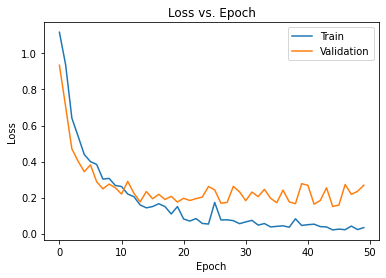

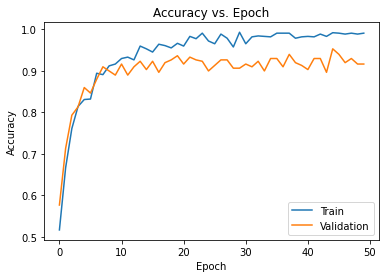

In [7]:
# PLOT
plt.plot(nRec,trainLossRec, label='Train')
plt.plot(nRec,validLossRec, label='Validation')
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(nRec,trainAccRec, label='Train')
plt.plot(nRec,validAccRec, label='Validation')
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [8]:
print("Best CNN Model")
net.load_state_dict(best_model_weights)
print("Training Accuracy: ", accuracy(net, train_loader))
print("Validation Accuracy: ", accuracy(net, valid_loader))
print("Test Accuracy: ", accuracy(net, test_loader))

Best CNN Model
Training Accuracy:  1.0
Validation Accuracy:  0.9533333333333334
Test Accuracy:  0.9133333333333333


In [9]:
torch.save(net.state_dict(), 'Best_CNN_Model.pt')